# Explore the Benefits of Rebalancing

In this exercise, we are going to explore the benefits of synthetic rebalancing of heavily imbalanced datasets, where a minority class of interest accounts for less than 0.1% of cases. 

Rebalancing can be useful for cases where we want to learn more of an otherwise small or underrepresented population segment by seeing more examples thereof. Of course, also a synthesizer can only leverage the data that it has seen. But if the method is data-efficient, and in particular more effective than the downstream data consumer, then it is possible to gain a significant advantage by synthetic rebalancing.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/rebalancing/rebalancing.png' width="600px"/>

In terms of evaluation, we again turn towards the Train-Synthetic-Test-Real approach to benchmark the predictive accuracy of a model that is trained on the (rebalanced) synthetic data, and compare that to a model trained on the (imbalanced) actual data. In addition, we will also benchmark against established methods for rebalancing, like naive upsampling as well as SMOTE. All four models are then evaluated on a holdout data, and compared in terms of predictive performance.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, as well as the same training and validation split, that was used in the Train-Synthetic-Test-Real tutorial. However, we will create an artificial imbalance of 0.1% of high-income records in the training data, by downsampling the minority class.

The code below will automatically create a rebalanced synthetic dataset using the MOSTLY AI Synthetic Data Platform.

Please replace `INSERT_YOUR_API_KEY` with your API KEY before executing the code below and make sure you have all the required packages installed (e.g. `scikit-learn`, `seaborn`, etc.).

In [1]:
#!pip install mostlyai scikit-learn seaborn lightgbm imblearn

from mostlyai import MostlyAI
import pandas as pd
from sklearn.model_selection import train_test_split

# fetch original data
df = pd.read_csv('https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz')
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [2]:
# split into training and validation
df_trn, df_hol = train_test_split(df, test_size=0.2, random_state=1)

print(f'training data with {df_trn.shape[0]:,} records and {df_trn.shape[1]} attributes')
print(f'holdout data with {df_hol.shape[0]:,} records and {df_hol.shape[1]} attributes')

training data with 39,073 records and 15 attributes
holdout data with 9,769 records and 15 attributes


In [3]:
# create an artificial imbalance of 0.1% of high-income records in the training data, by downsampling the minority class 

def create_imbalance(df, target, ratio):
    val_min, val_maj = df[target].value_counts().sort_values().index
    df_maj = df.loc[df[target]==val_maj]
    n_min = int(df_maj.shape[0]/(1-ratio)*ratio)
    df_min = df.loc[df[target]==val_min].sample(n=n_min, random_state=1)
    df_maj = df.loc[df[target]==val_maj]
    df_imb = pd.concat([df_min, df_maj]).sample(frac=1, random_state=1)
    return df_imb

trn = create_imbalance(df_trn, 'income', 1/1000)
print(f'Created imbalanced training data with {trn.shape[0]:,} records and {trn.shape[1]} attributes')

Created imbalanced training data with 29,754 records and 15 attributes


In [41]:
# initialize client
mostly = MostlyAI(api_key='INSERT_YOUR_API_KEY')

# train a generator on the original training data
g = mostly.train(data=trn, name='Rebalancing Tutorial Census')
 
# generate a synthetic dataset with rebalancing of the income column to 50% ">50K" category
sd = mostly.generate(generator=g, config={
    'name': 'Rebalancing Tutorial Census',
    'tables': [{
        'name': 'data',
        'configuration': {
            'rebalancing': {
                'column': 'income', 
                'probabilities': {'>50K': 0.5}
             }
        }
    }]
})
 
# start using it
syn = sd.data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created generator ]8;id=145957;https://app.mostly.ai/d/generators/bdc54bf9-ef9b-47d8-bf26-d58db00e4b46\bdc54bf9-ef9b-47d8-bf26-d58db00e4b46]8;;\

Started generator training

Output()

🎉 Your generator is ready! Use it to create synthetic data. Share it so others can do the same.

Created synthetic dataset ]8;id=714358;https://app.mostly.ai/d/synthetic-datasets/2b7cf381-c606-4a44-875a-e3d88cfe24b5\2b7cf381-c606-4a44-875a-e3d88cfe24b5]8;;\ with generator ]8;id=964355;https://app.mostly.ai/d/generators/bdc54bf9-ef9b-47d8-bf26-d58db00e4b46\bdc54bf9-ef9b-47d8-bf26-d58db00e4b46]8;;\

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Share it so others can do the same.

Created synthetic data with 29,754 records and 15 attributes


## Explore Synthetic Data

### Samples Random Records

Let's first show 10 randomly sampled original records, from the imbalanced dataset. Try executing the cell multiple times, to see different samples. Still, due to the strong imbalance, you will hardly ever encounter a sample of the high income class (i.e. `income` being `>50K`).

In [31]:
trn.sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
27284,27.0,Private,80165.0,Some-college,10.0,Separated,Adm-clerical,Unmarried,White,Female,0.0,0.0,20.0,United-States,<=50K
19185,30.0,Private,171598.0,Bachelors,13.0,Married-spouse-absent,Sales,Not-in-family,White,Female,0.0,0.0,50.0,United-States,<=50K
34543,68.0,?,110931.0,HS-grad,9.0,Widowed,?,Not-in-family,White,Female,0.0,0.0,32.0,United-States,<=50K
36233,19.0,Private,194608.0,9th,5.0,Never-married,Handlers-cleaners,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
9044,37.0,Private,126011.0,Assoc-voc,11.0,Divorced,Tech-support,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
36936,18.0,Self-emp-not-inc,194091.0,11th,7.0,Never-married,Farming-fishing,Own-child,White,Male,0.0,0.0,24.0,United-States,<=50K
39345,41.0,Private,200009.0,10th,6.0,Divorced,Handlers-cleaners,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
17262,28.0,Private,67218.0,7th-8th,4.0,Married-civ-spouse,Sales,Other-relative,White,Male,0.0,0.0,40.0,United-States,<=50K
21958,43.0,Private,117915.0,Masters,14.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
17484,38.0,Private,91857.0,Some-college,10.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,41.0,United-States,<=50K


Let's now display 10 randomly sampled synthetic records. Again, run the cell multiple times. This time, you should see that the records are evenly distributed across the two `income` classes.

In [32]:
syn.sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
3601,59,Local-gov,235189,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,>50K
29341,20,?,42978,5th-6th,3,Never-married,?,Not-in-family,White,Female,0,0,40,Mexico,>50K
27674,22,?,121210,Some-college,10,Never-married,?,Own-child,Amer-Indian-Eskimo,Female,0,0,30,United-States,<=50K
2592,55,Local-gov,80632,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,20,United-States,>50K
6989,31,Federal-gov,309684,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
19573,41,Private,195293,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
8325,64,Self-emp-inc,95282,HS-grad,9,Divorced,Sales,Other-relative,White,Female,0,0,40,United-States,>50K
13686,40,Private,234840,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
29144,38,Private,191578,Masters,14,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
15822,50,Private,188067,Some-college,10,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,40,United-States,>50K


### Sample Female Doctors with a High Income

Let's now investigate all female doctors with a high income. But, it turns out there are actually none in the original data, thus we won't be able to learn anything.

In [33]:
trn[(trn['income']=='>50K') & (trn.sex=='Female') & (trn.education=='Doctorate')]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income


However, the synthetic data does contain a list of realistic, statistically sound female doctors with a high income, that allow to learn about this particular subsegment.

In [34]:
syn[(syn['income']=='>50K') & (syn.sex=='Female') & (syn.education=='Doctorate')].sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
9115,60,Self-emp-not-inc,56352,Doctorate,16,Divorced,Prof-specialty,Other-relative,White,Female,0,0,36,United-States,>50K
7636,38,State-gov,192008,Doctorate,16,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,20,India,>50K
13594,40,Local-gov,189944,Doctorate,16,Never-married,Prof-specialty,Unmarried,White,Female,0,0,56,United-States,>50K
4615,24,Private,37641,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,>50K
11746,24,Private,99876,Doctorate,16,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,12,United-States,>50K
25195,33,Federal-gov,337989,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,0,40,Germany,>50K
22667,73,Self-emp-not-inc,255930,Doctorate,16,Widowed,Sales,Not-in-family,White,Female,0,0,20,United-States,>50K
24451,35,Private,119989,Doctorate,16,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K
27664,33,Private,127859,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,United-States,>50K
7943,36,Private,192904,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,1470,40,United-States,>50K


## Compare ML Performance via TSTR

In [35]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'income'
target_val = '>50K'

def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    f1 = f1_score(y_hol, probs>0.5, average='macro')
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name=target_col).reset_index(drop=True)
    ], axis=1)
    sns.displot(data=probs_df, x='probability', hue=target_col, bins=20, multiple="stack")
    plt.title(f"AUC: {auc:.1%}, F1 Score: {f1:.2f}", fontsize = 20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

In [36]:
df_hol_min = df_hol.loc[df_hol['income']=='>50K']
print(f"Holdout data consists of {df_hol.shape[0]:,} records",
      f"with {df_hol_min.shape[0]:,} samples from the minority class")

Holdout data consists of 9,769 records with 2,339 samples from the minority class


### Train model on the original imbalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.700688


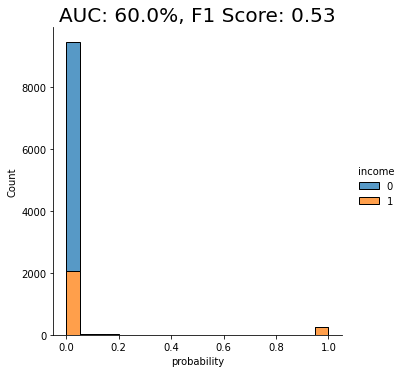

In [37]:
X_trn, y_trn = prepare_xy(trn)
model_trn = train_model(X_trn, y_trn)
auc_trn = evaluate_model(model_trn, df_hol)

With an AUC of about 60%, the model trained on the imbalanced dataset is just as good as a flip of a coin. I.e., the downstream LightGBM model is not able to learn any signal due to the low number of samples.

### Train model on naively rebalanced training data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.99988


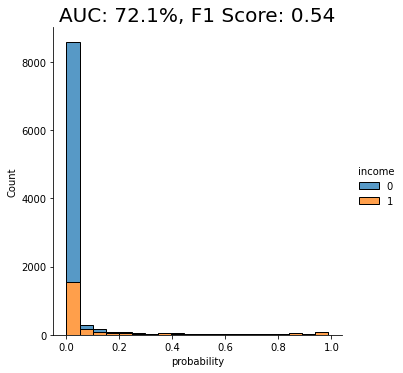

In [38]:
from imblearn.over_sampling import RandomOverSampler
X_trn, y_trn = prepare_xy(trn)
sm = RandomOverSampler(random_state=1)
X_trn_up, y_trn_up = sm.fit_resample(X_trn, y_trn)
model_trn_up = train_model(X_trn_up, y_trn_up)
auc_trn_up = evaluate_model(model_trn_up, df_hol)

Random "naive" upsampling [[2](#refs)], which simply adds minority samples multiple times to achieve a balance, only marginally helps the downstream model in this case.

### Train model on SMOTE rebalanced training data

SMOTE upsampling [[3](#refs)], which creates novel (non-privacy-preserving) samples by interpolating between neighboring samples, does boost the performance of the downstream model to close to 80%.

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.999955


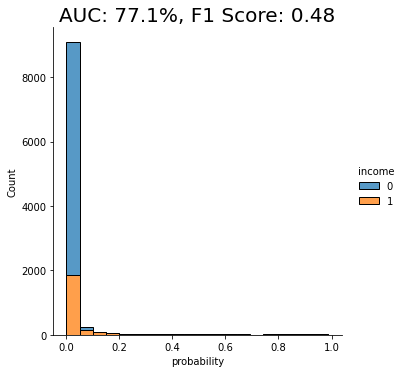

In [39]:
from imblearn.over_sampling import SMOTENC
import numpy as np

X_trn, y_trn = prepare_xy(trn)
categorical_mask = (X_trn.dtypes == 'category').tolist()
categorical_features_indices = [i for i, is_categorical in enumerate(categorical_mask) if is_categorical]
sm = SMOTENC(categorical_features=categorical_features_indices, random_state=1)
X_trn_smote, y_trn_smote = sm.fit_resample(X_trn, y_trn)
model_trn_smote = train_model(X_trn_smote, y_trn_smote)
auc_trn_smote = evaluate_model(model_trn_smote, df_hol)

### Train model on balanced synthetic data

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.581585


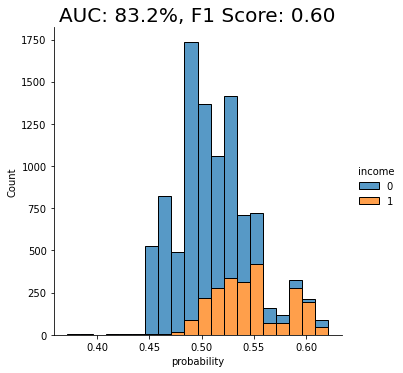

In [40]:
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)
auc_syn = evaluate_model(model_syn, df_hol)

Both, performance measures, the AUC [[4](#refs)] as well as the macro-averaged F1 score [[5](#refs)] are significantly better for the model that was trained on synthetic data, than if it were trained on any of the other methods. This is a strong proof of value of synthetic rebalancing for learning more about a small sub-group within the population.

## Conclusion

For the given dataset and the given synthesizer we can see, that both data analysts as well as AI engineers can learn more from a balanced synthetic dataset when compared to the imbalanced original dataset. Note, that the actual lift in performance may vary, depending on the dataset, the predictive task, and the chosen ML model.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to repeat the experiments for different class imbalances - see the helper script at the bottom to create such experiments
* to repeat the experiments for different datasets, ML models, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
1. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html